# Spaceship Titanic
The project inspects Spaceship Titanic Dataset from Kaggle. 

The primary objectives are to clean the data, perform exploratory data analysis, statistical analysis, and apply various machine learning models for target variable Transported prediction. 

Transported predictions will apploaded to Kaggle as a compatition entry, performance goal is 79% accuracy.

## Dataset
Dataset can be downloaded from [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/overview).

In [318]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
import missingno as msno

from imblearn.over_sampling import SMOTE
import joblib

from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, auc, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold
from scipy import stats
import numpy as np
import pandas as pd

from sklearn.feature_selection import mutual_info_classif

from xgboost import XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer

import warnings
from sklearn.exceptions import UndefinedMetricWarning


pd.plotting.register_matplotlib_converters()
%matplotlib inline

%load_ext autoreload
%autoreload 2
from help_tool import help_tool


"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data download and Cleaning
Checking for duplicates and empty values, as well as the size of dataset:

* Dataset has 8693 observations and 14 features
* Some features are missing 2% of their data
* No duplicates

In [319]:
titanic = help_tool.csv_download(r'Archive\spaceship-titanic\train.csv')
help_tool.first_look(titanic)

Dataset has 8693 observations and 14 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
PassengerId,object,0,0.0
HomePlanet,object,201,2.3
CryoSleep,object,217,2.5
Cabin,object,199,2.3
Destination,object,182,2.1
Age,float64,179,2.1
VIP,object,203,2.3
RoomService,float64,181,2.1
FoodCourt,float64,183,2.1
ShoppingMall,float64,208,2.4


In [320]:
titanic.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Feature separation
### PassengerId, Name, Cabin
Some columns have multitude of information encoded:
* PassengerId - Group and Group_Id
* Cabin: 
    * Deck - values A:G, T will be converted to integers 1-6. T is an unconventional deck name, thus unconventional -1 was assigned to it.
    * Deck_num -  
    * Side - has only 2 values S (Starboard) and P (Port), will be made to bool feature.

These features will be separeted.

In [321]:
def cleaning(df):
    # PassengerId
    # Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
    df[['Group', 'Group_Id']] = df['PassengerId'].str.split('_', expand=True)

    # Name
    # Separating last name for family identifications
    df[['First_Name', 'Last_Name']] = df['Name'].str.split(' ', expand=True)

    # Cabin
    # Form deck/num/side, where side can be either P for Port or S for Starboard.
    df[['Deck', 'Deck_num', 'Side']] = df['Cabin'].str.split('/', expand=True)
 

    
    for feature in ['CryoSleep', 'VIP', 'Transported', 'Group', 'Group_Id', 'Deck_num']:
        try:
            df[feature] = df[feature].astype(int)
        except: 
            df[feature] = df[feature].astype(float)


    df.drop(columns=['PassengerId', 'Name'], inplace=True)
    return df


titanic = cleaning(titanic)

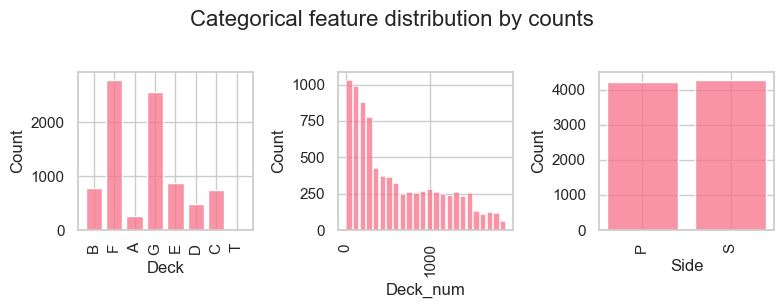

In [322]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

axes = axes.flatten()

for i, col in enumerate(['Deck', 'Deck_num', 'Side']):
    sns.histplot(data=titanic, x=col, multiple="dodge", shrink=.8, 
                 ax=axes[i])
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

Deck can be encoded as well as assigned a Deck_Class:
* Upper Decks (A, B, C)
* Middle Decks (D, E)
* Lower Decks (F, G)
* Service Decks (Below G)

Side has only 2 available values.

In [323]:
def deck_clean(df):

    # Available Deck values are A-G, T
    df['Deck'] = df['Deck'].replace({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8})

    # Deck Class
    df.loc[df['Deck'] < 4, 'Deck_Class'] = 1 # Upper Decks
    df.loc[df['Deck'].isin([4, 5]), 'Deck_Class'] = 2 # Middle Decks
    df.loc[df['Deck'].isin([6, 7]), 'Deck_Class'] = 3 # Lower Decks 
    df.loc[df['Deck'] > 7, 'Deck_Class'] = 4 # Service Decks

    # Side has only 2 values and will be updated to bool feature
    df['Side'] = (df['Side'] == 'S').astype(int)

    return df

titanic = deck_clean(titanic)

### Amenities
Amenities describe how much money the passanger has paid for ship luxuries.

In [324]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

Passengers in cryosleep are confined to their cabins, yet some of amenities values are missing. These values can be filled in with 0 (money spent).

In [325]:
titanic[titanic['CryoSleep'] == 1][amenities].isna().sum()

RoomService     68
FoodCourt       70
ShoppingMall    96
Spa             65
VRDeck          62
dtype: int64

Passangers that CryoSleep spend 0 money on amenities.

In [326]:
titanic[titanic['CryoSleep'] == 1][amenities].sum()

RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

In [327]:
condition = titanic['CryoSleep'] == 1
titanic.loc[condition, amenities] = titanic.loc[condition, amenities].fillna(0)

Adding total money spent:

In [328]:
titanic['Amenities'] = titanic[amenities].sum(axis=1)

In [329]:
amenities = amenities + ['Amenities']

### Family members
People in a group are often family members, but not always. For example, last name Acobsond is share by people in different groups.

In [330]:
def family(df):
    df['GroupSize'] = df.groupby(['Group', 'Last_Name'])['Group'].transform('size')

    # Step 2: Create 'Family' column based on group size
    df['Family'] = (df['GroupSize'] >= 2).astype(int)
  
    return df

titanic = family(titanic)

# Analysis

In [331]:
titanic.drop(columns=['Cabin', 'First_Name', 'Last_Name', 'Amenities', 'Deck_Class']).columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Group',
       'Group_Id', 'Deck', 'Deck_num', 'Side', 'GroupSize', 'Family'],
      dtype='object')

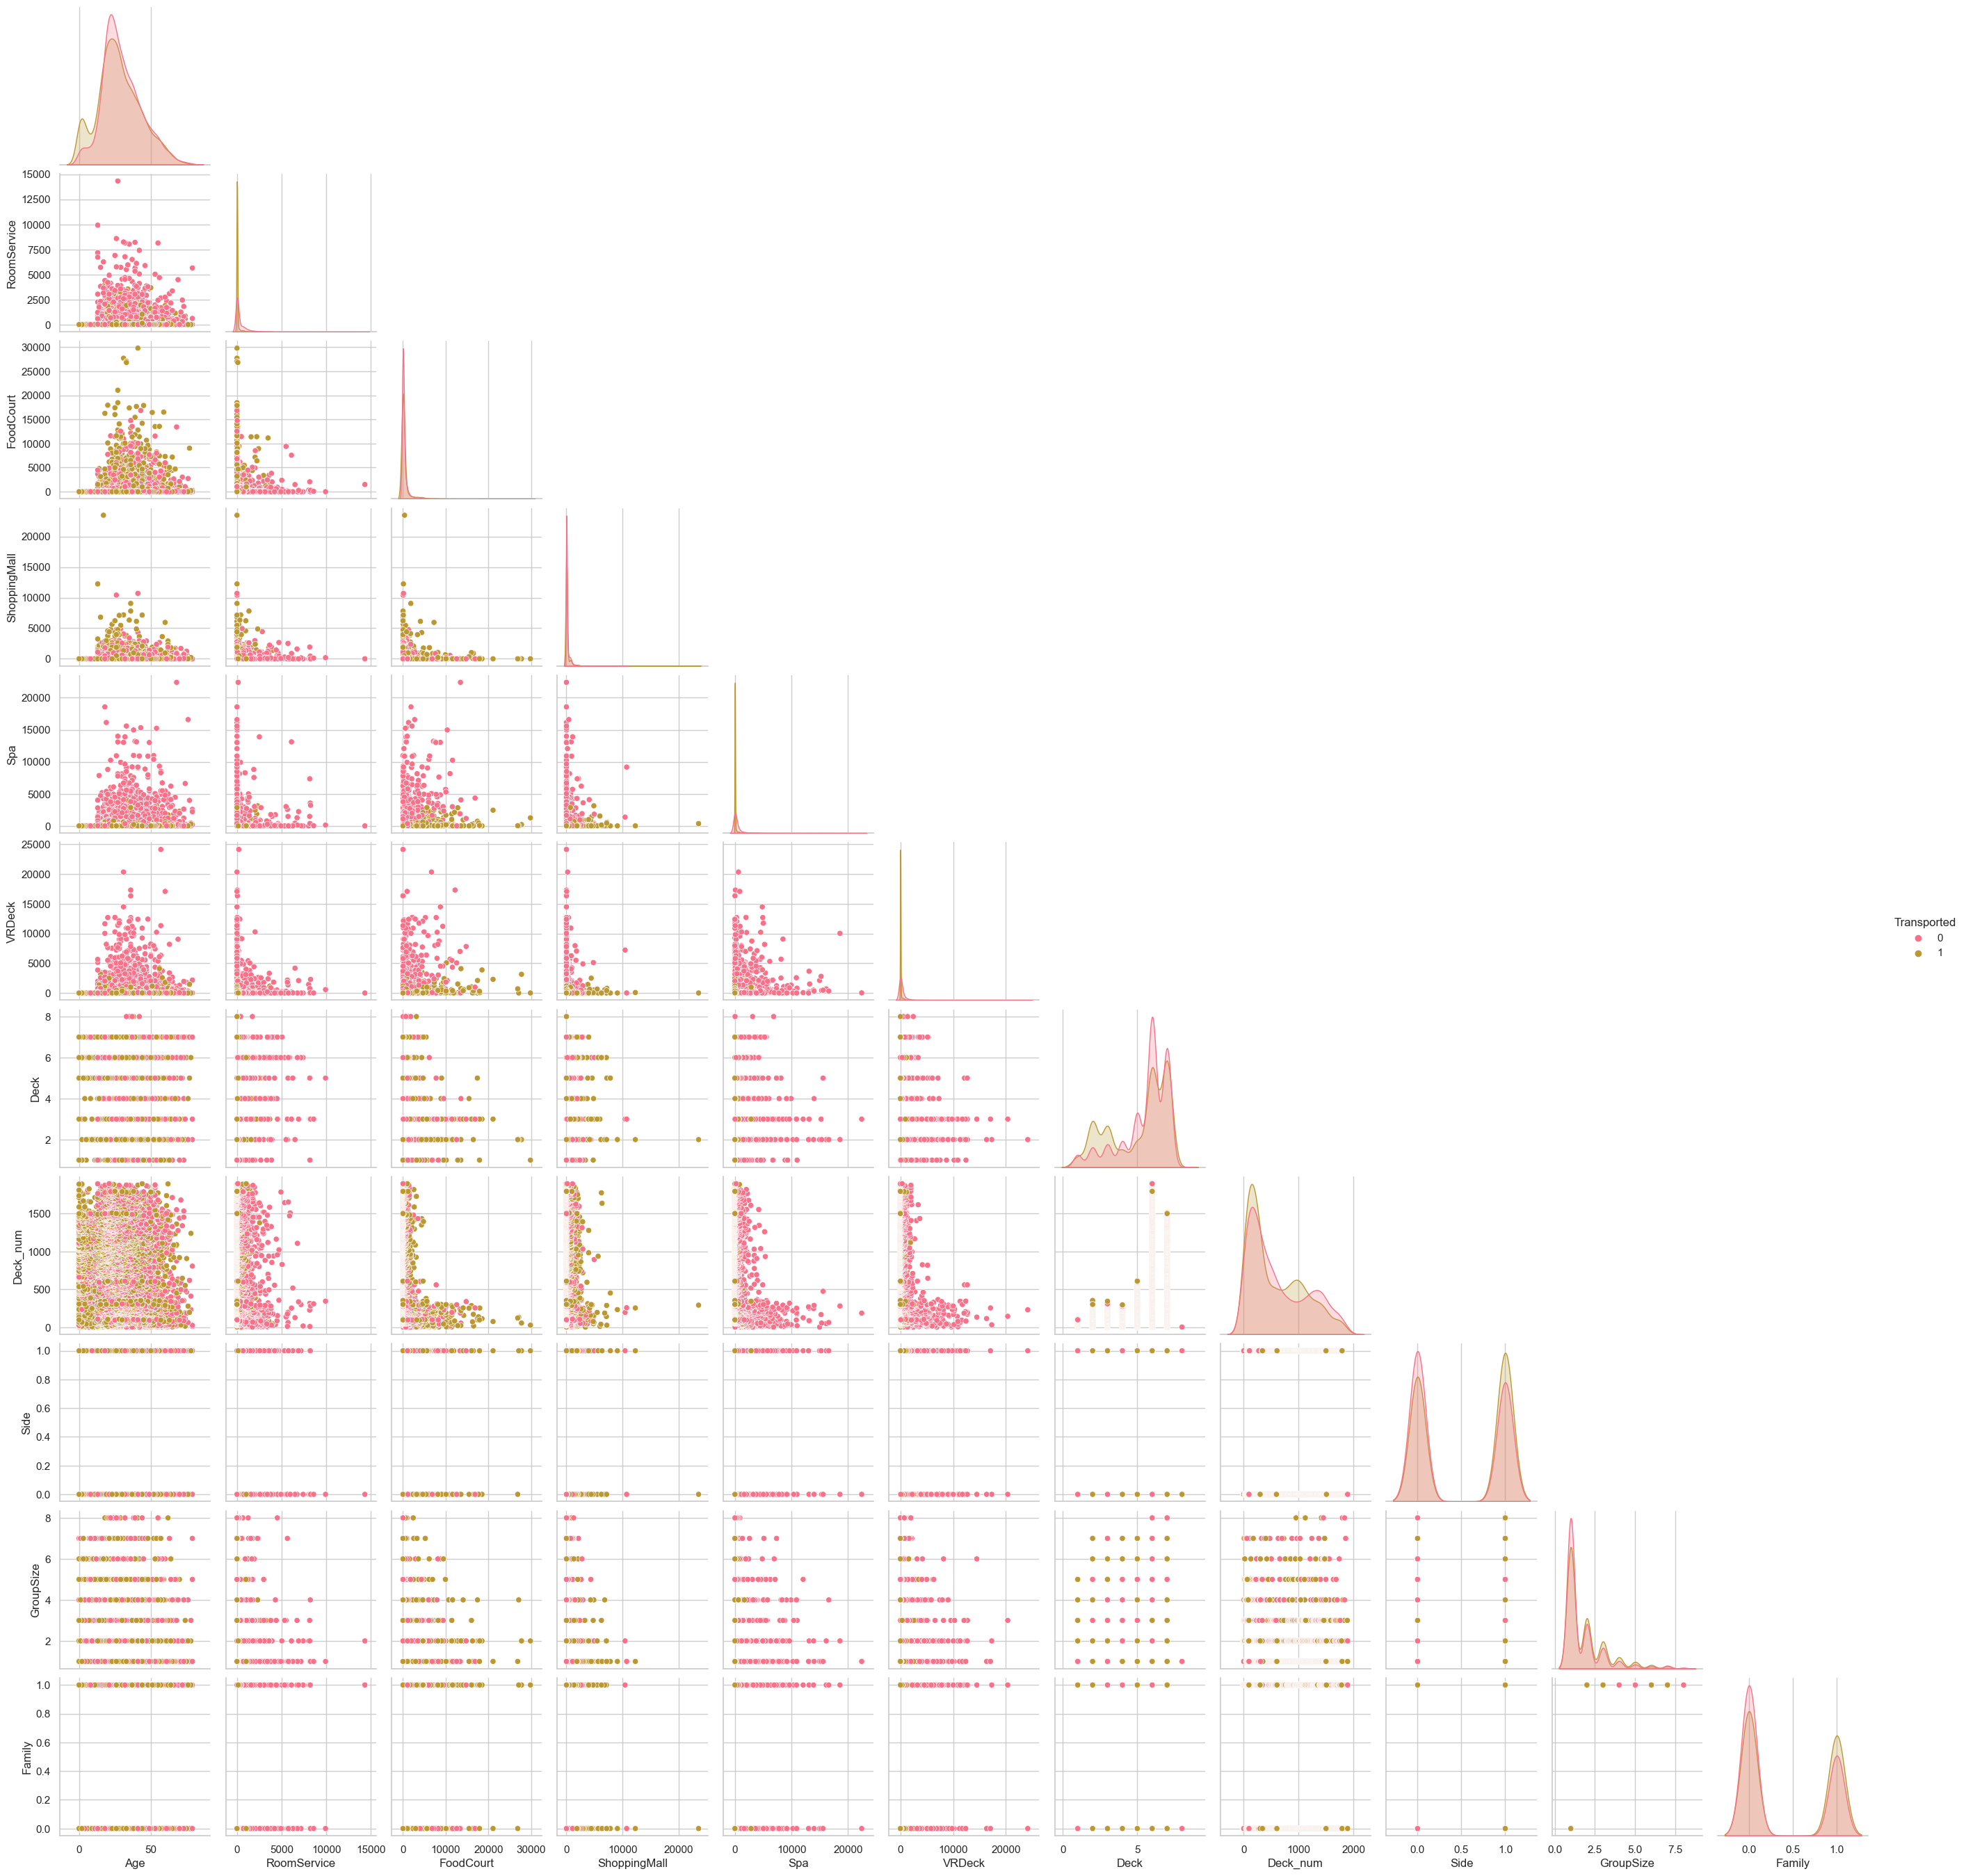

In [332]:
sns.pairplot(titanic.drop(columns=['Cabin', 'First_Name', 'Last_Name', 'Amenities', 'Deck_Class', 'CryoSleep', 'VIP', 'Group', 'Group_Id']), corner=True, hue='Transported')
plt.show()

Amenities are log distributed and will be log transformed to make them normaly distributes.

In [333]:
titanic_log = titanic.copy()

# Updating spent amount to +1, when spent was 0 (for log transformation to work)
titanic_log[amenities] = titanic_log[amenities].replace({0:1})
titanic_log[amenities] = titanic_log[amenities].apply(np.log)

## Continues features
Continues features are made of:
* Amenities in Spaceship: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck look log distributed and will be log transformed.
* Age - which ranges 0-79 years. With median mid 20s. Outliers are above ~65, but it's not uncommon for people up to 80 to travel and these will be left in.
* Group 
* Deck_num

Age


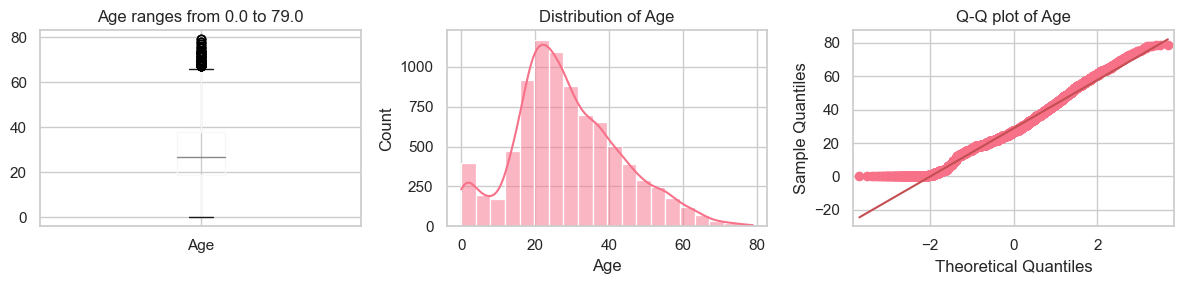

Group


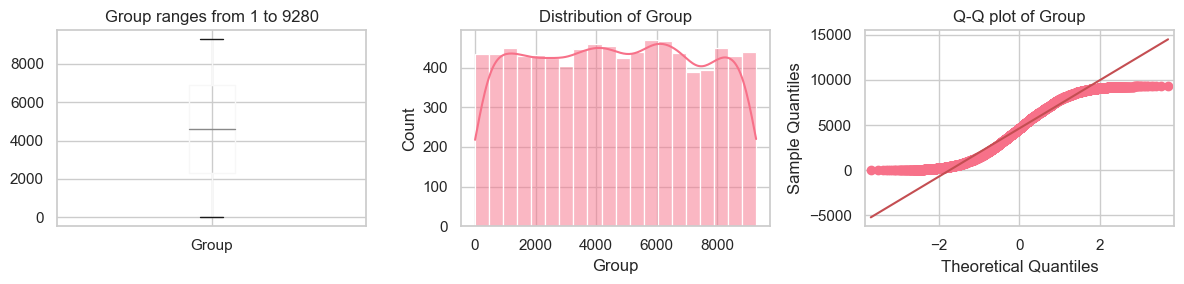

Deck_num


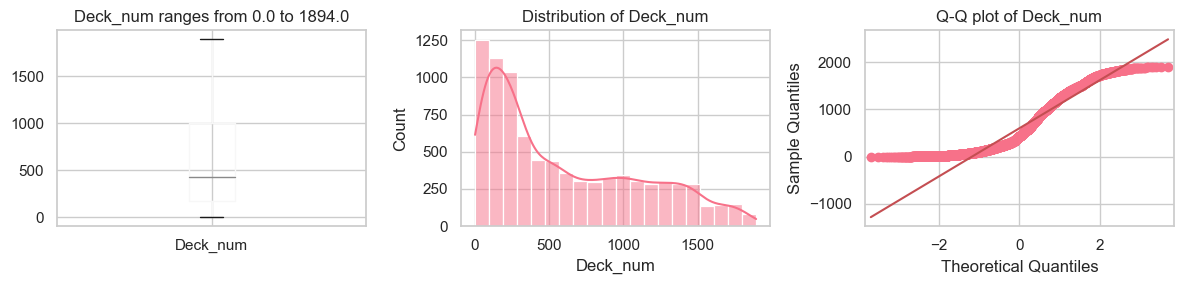

RoomService


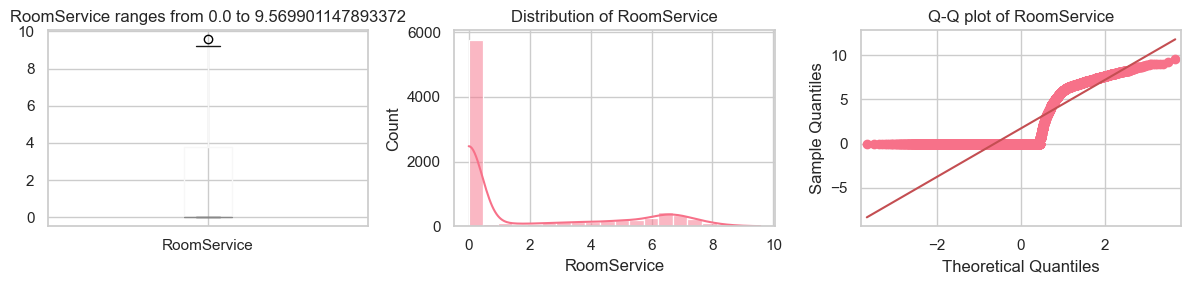

FoodCourt


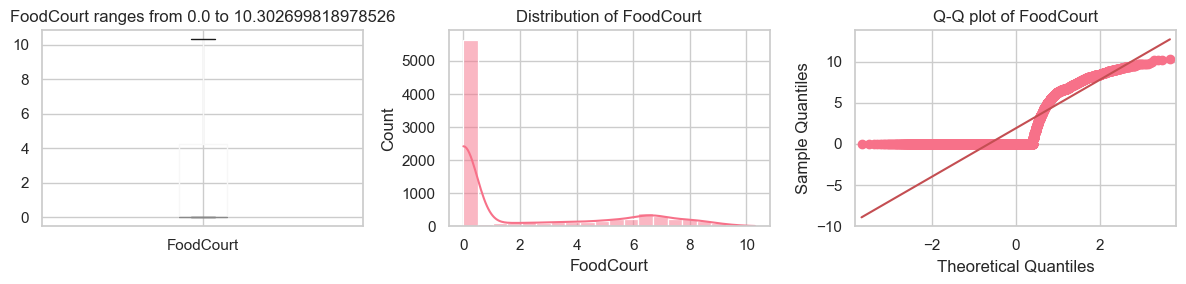

ShoppingMall


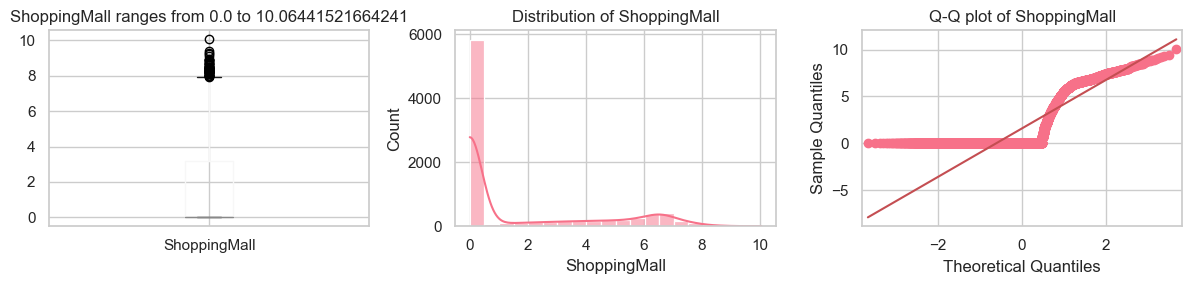

Spa


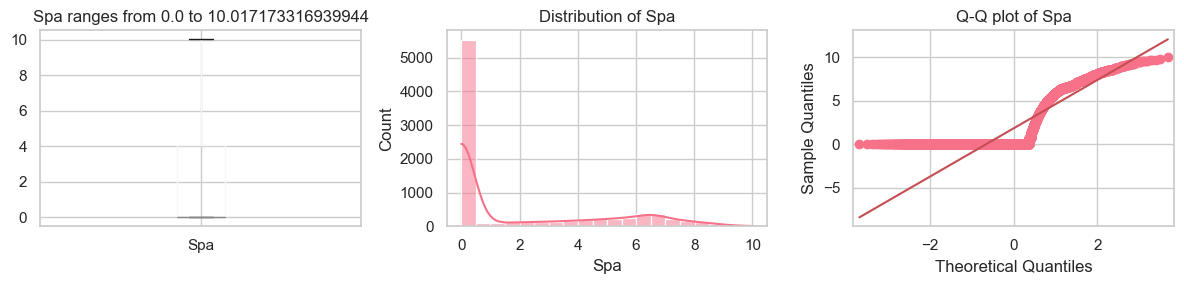

VRDeck


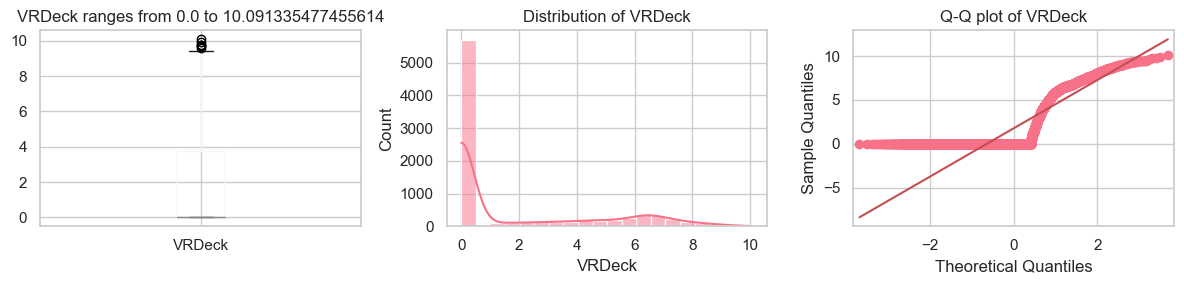

Amenities


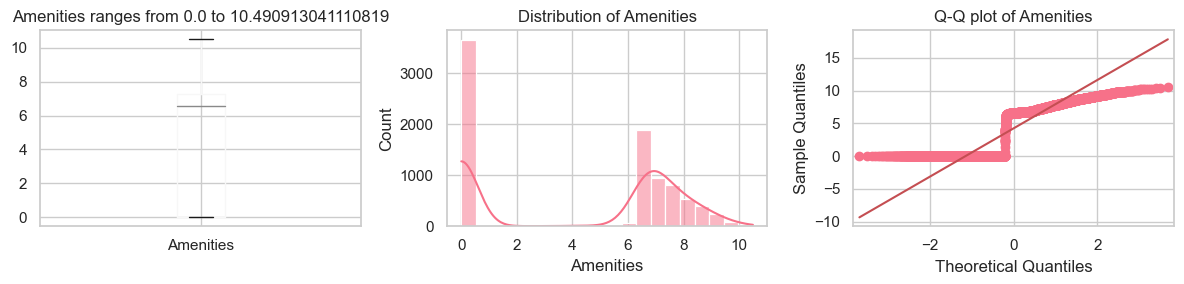

In [334]:
continuous_features = ['Age', 'Group', 'Deck_num'] + amenities

help_tool.distribution_check(titanic_log[continuous_features])

Let's check correlation of continues features after log transformation

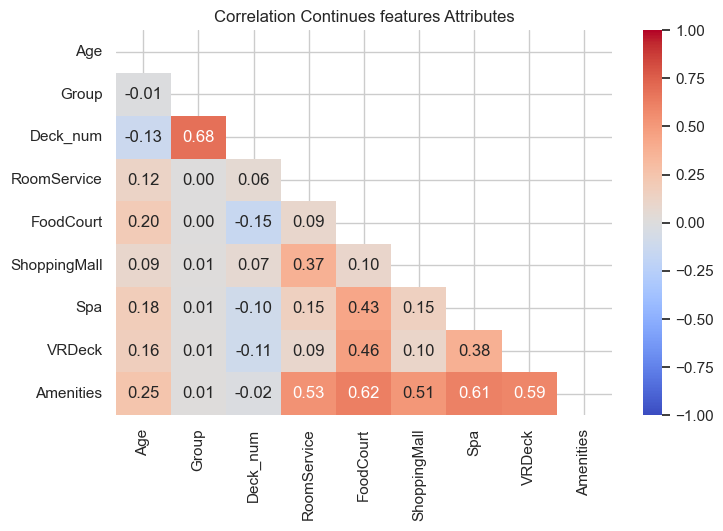

In [335]:
help_tool.heatmap(titanic_log[continuous_features], 'Continues features', 'pearson')

* No feature pairs with strong positive or negative correlation (+/- 1)
* Deck_num and Group has moderate (0.5-0.75) correlation. Groups must be assigned to based on Deck_num, Side and Deck. 
* Group is pats of passanger identification and will not be used in model training.
* Amenities feature is a sum of all other amenities, thus is mildly correlated.

Group have unique combinations for Deck_num and Deck, which depend on one another.

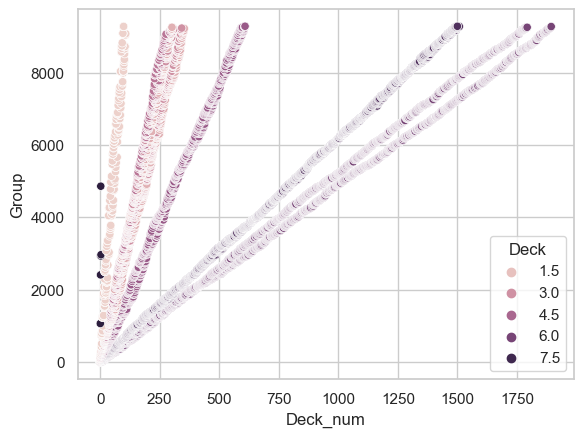

In [336]:
sns.scatterplot(titanic, x="Deck_num", y="Group", hue="Deck")
plt.show()

Is the Age dependency on Amenities?

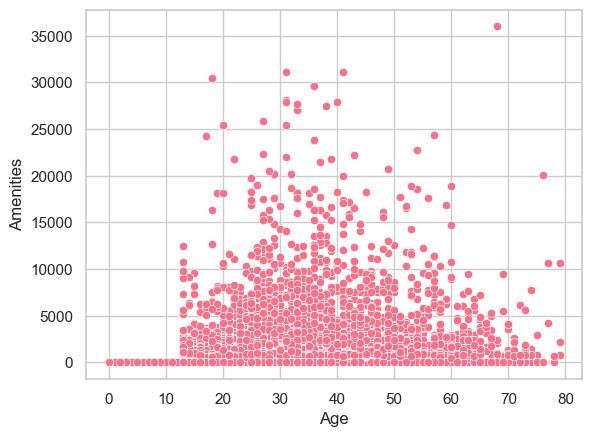

In [337]:
sns.scatterplot(titanic, x="Age", y="Amenities")

plt.show()

People under 13 years old don't make amenities pursaches.

In [338]:
titanic[titanic['Amenities'] != 0][['Age', 'Amenities']].min()

Age          13.0
Amenities     1.0
dtype: float64

In [339]:
condition = titanic['Age'] < 13
titanic.loc[condition, amenities] = titanic.loc[condition, amenities].fillna(0)

## Categorical features
* Target feature Transported seams balanced
* VIP is imbalanced.


In [340]:
category_features = ['HomePlanet', 'Destination', 'Deck', 'Group_Id', 'Deck_Class', 'GroupSize']
binary_features = ['CryoSleep', 'VIP', 'Transported', 'Side']

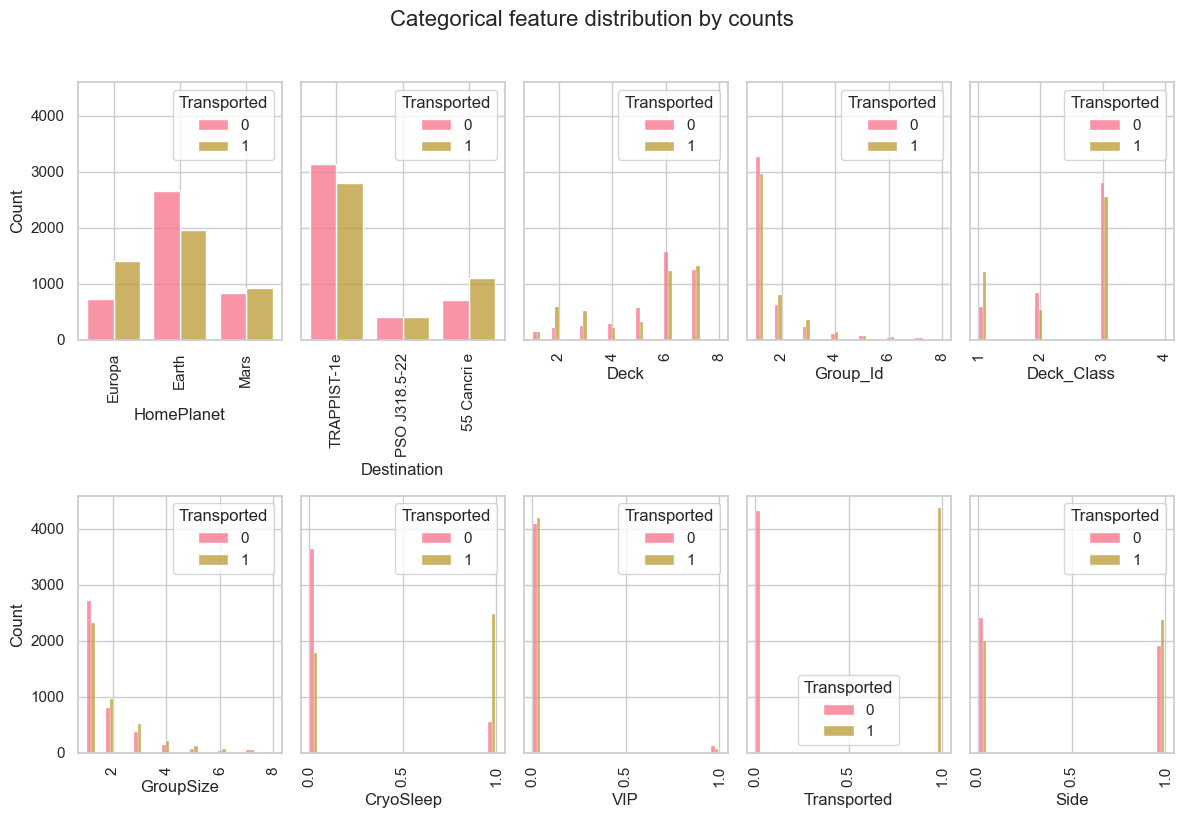

In [341]:
fig, axes = plt.subplots(2, 5, figsize=(12, 8), sharey=True)

axes = axes.flatten()

for i, col in enumerate(category_features + binary_features):
    sns.histplot(data=titanic, x=col, bins=20, multiple="dodge", shrink=.8, 
                 ax=axes[i], hue='Transported', legend=True)
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

* Most people travel alone

### Distance encoding
Distances from Earth to:
* Earth to Mars: 7.5 light minutes.
* Earth to Europa: 40 light minutes.

* Earth to TRAPPIST-1e: Approximately 39 light-years away.
* Earth to 55 Cancri e: Approximately 41 light-years away.
* Earth to PSO J318.5-22: Approximately 80 light-years away. 

PSO J318.5-22 is a rogue planet, not bound to any star. Its distance is not directly comparable in terms of solar distances, as it floats in the vastness of space without orbiting a star like the others.

* encoding 'HomePlanet', 'Destination' with numbers for correlation check

In [342]:
def planet_encoding(df):
    df.loc[df['HomePlanet'] == 'Earth', 'HomePlanet_Encoded'] = 1
    df.loc[df['HomePlanet'] == 'Mars', 'HomePlanet_Encoded'] = 2
    df.loc[df['HomePlanet'] == 'Europa', 'HomePlanet_Encoded'] = 3

    df.loc[df['Destination'] == 'TRAPPIST-1e', 'Destination_Encoded'] = 1
    df.loc[df['Destination'] == '55 Cancri e', 'Destination_Encoded'] = 2
    df.loc[df['Destination'] == 'PSO J318.5-22', 'Destination_Encoded'] = 3

    return df

titanic = planet_encoding(titanic)

### Family Spending

In [343]:
titanic.columns

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Group', 'Group_Id', 'First_Name', 'Last_Name', 'Deck',
       'Deck_num', 'Side', 'Deck_Class', 'Amenities', 'GroupSize', 'Family',
       'HomePlanet_Encoded', 'Destination_Encoded'],
      dtype='object')

In [344]:
for feature in amenities:
    titanic[f'Avg_{feature}'] = titanic.groupby(['Group', 'GroupSize'])[feature].transform('mean')

In [345]:
avg_amenities = ['Avg_Amenities', 'Avg_RoomService', 'Avg_FoodCourt', 'Avg_ShoppingMall',
       'Avg_Spa', 'Avg_VRDeck']

Avg_Amenities


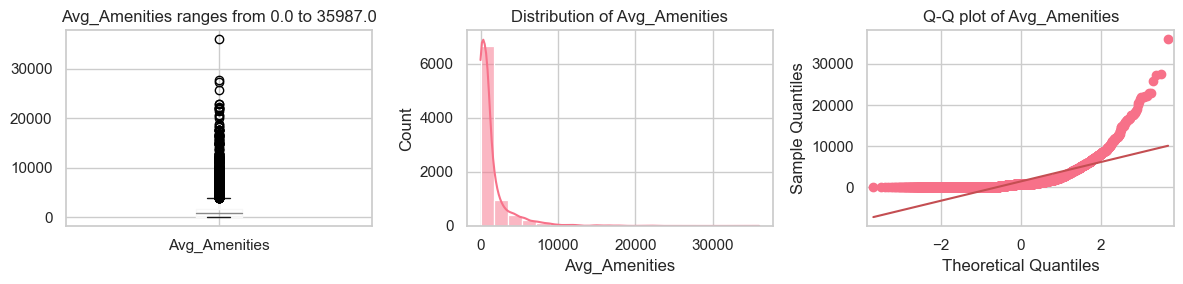

Avg_RoomService


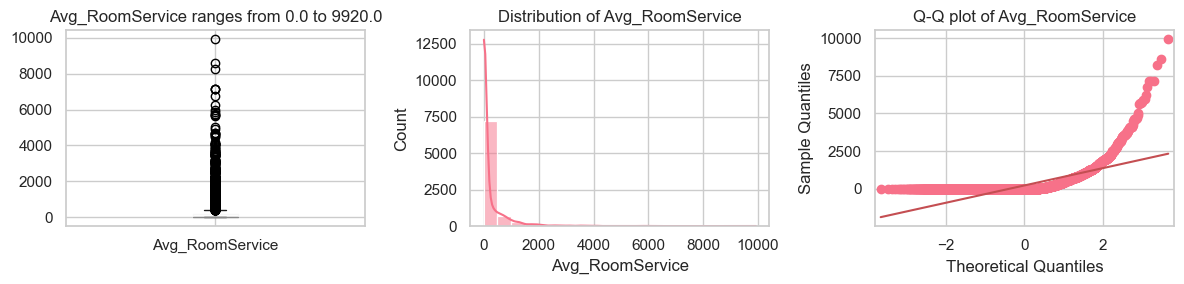

Avg_FoodCourt


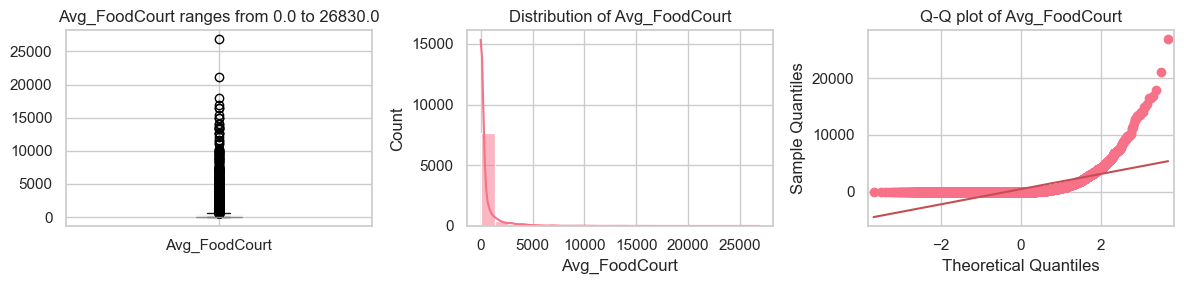

Avg_ShoppingMall


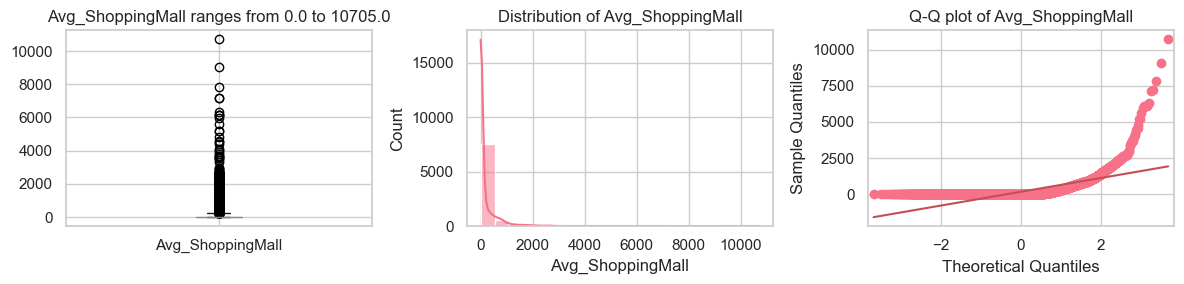

Avg_Spa


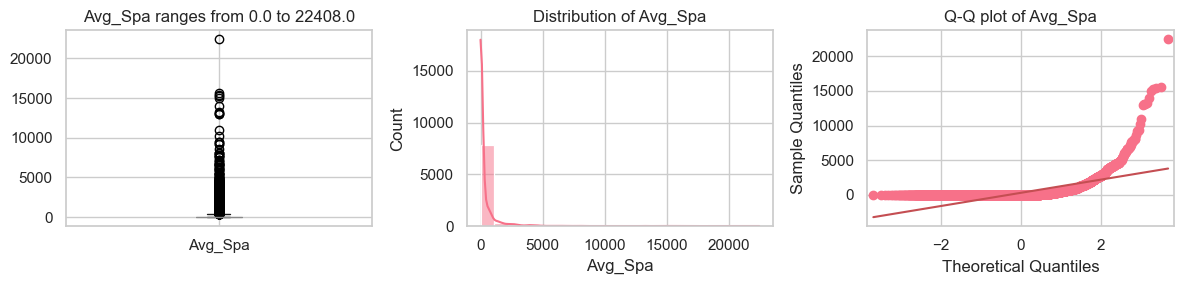

Avg_VRDeck


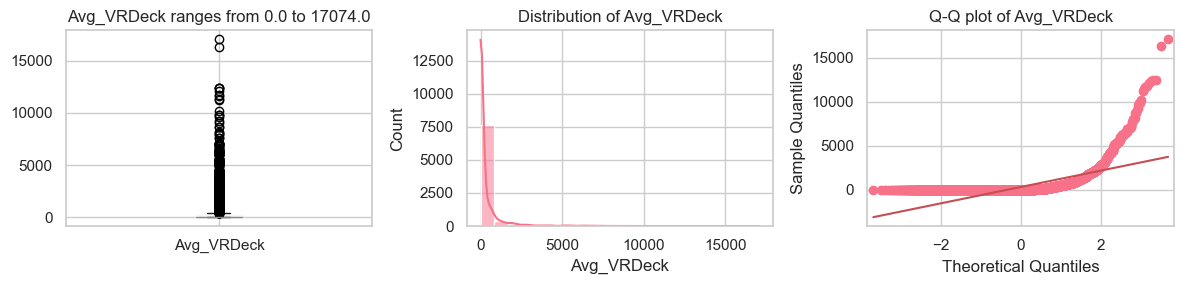

In [346]:
help_tool.distribution_check(titanic[avg_amenities])

### VIP 
VIP variance is 2.3% for minority class 1. Let's check if there's a significant relationship to traget feature Transported

In [347]:
titanic['VIP'].var() *100

2.289263414540038

Null Hypothesis (H0): There is no relationship between 'VIP' and 'Transported'. <br>
Alternative Hypothesis (H1): There is a relationship between 'VIP' and 'Transported'.

In [348]:
help_tool.chi_squared_test(titanic, ('VIP','Transported'))

Chi-squared statistic: 11.542020738162797. P-value: 0.0006804064556968345. Reject the null hypothesis.


A lot of VIP values are missing, let's check the profile of VIP passanger:
* 95% confidence interval for VIP age is 35-39 years old and not overlapping with non VIP age (28).

In [349]:
print('VIP: ')
help_tool.confidence_intervals(
    titanic[titanic['VIP'] == 1]['Age'], 'Continuous')
print('NOT VIP: ')
help_tool.confidence_intervals(
    titanic[titanic['VIP'] == 0]['Age'], 'Continuous')

VIP: 
Confidence Interval: [35.84, 39.06]
NOT VIP: 
Confidence Interval: [28.33, 28.95]


* VIP passangers spent >50% more money on amenities

In [350]:
print('VIP: ')
help_tool.confidence_intervals(
    titanic[titanic['VIP'] == 1]['Amenities'], 'Continuous')
print('NOT VIP: ')
help_tool.confidence_intervals(
    titanic[titanic['VIP'] == 0]['Amenities'], 'Continuous')

VIP: 
Confidence Interval: [3713.93, 5137.02]
NOT VIP: 
Confidence Interval: [1313.74, 1429.27]


Do VIP passangers spent significantly more money (alpha = 0.05) on individual amenities?


Null Hypothesis: VIP passangers don't spent significantly more money on Amenities.<br>
Alternative Hypotheses: VIP passangers spent significantly more money on Amenities.

In [351]:
for feature in amenities:
    help_tool.significance_t_test(titanic, feature, 'VIP', 0, 1)

p-value = nan between RoomService and VIP. Fail to reject null hypothesis
p-value = nan between FoodCourt and VIP. Fail to reject null hypothesis
p-value = nan between ShoppingMall and VIP. Fail to reject null hypothesis
p-value = nan between Spa and VIP. Fail to reject null hypothesis
p-value = nan between VRDeck and VIP. Fail to reject null hypothesis
p-value = 0.0000 between Amenities and VIP. Reject null hypothesis


* VIP passangers spent significantly more money on amenities overall, but not on any one amenity.

Do VIP passangers come from/ to a specific planet or are staying in a specific Deck?

Null Hypothesis: VIP passangers have no dependency on HomePlanet, Destination or Deck.<br>
Alternative Hypotheses: Some HomePlanet, Destination or Deck have significant more VIP passangers.

In [352]:
for feature in ['HomePlanet', 'Destination_Encoded', 'Deck_Class']:
    help_tool.significance_t_test(titanic, feature, 'VIP', 0, 1)

p-value = nan between HomePlanet and VIP. Fail to reject null hypothesis
p-value = nan between Destination_Encoded and VIP. Fail to reject null hypothesis
p-value = nan between Deck_Class and VIP. Fail to reject null hypothesis


* VIP passangers come from each of 3 panets, independent of destination and Deck location.

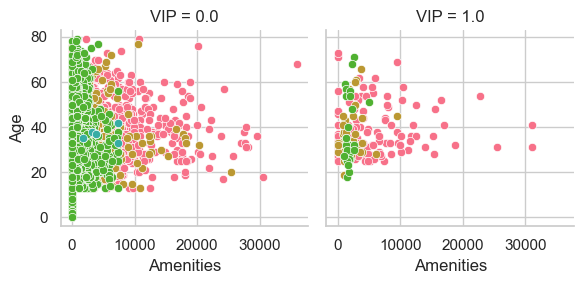

In [353]:
g = sns.FacetGrid(titanic, col="VIP", hue='Deck_Class')
g.map(sns.scatterplot, "Amenities", "Age")

plt.show()

There's no clear way of imputing VIP:
* All Deck Classes apply for VIP
* 35-39 years old if 95% confidence of VIP, but the age distribution is spread.
* 

In [354]:
amenities

['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Amenities']

## Correlation

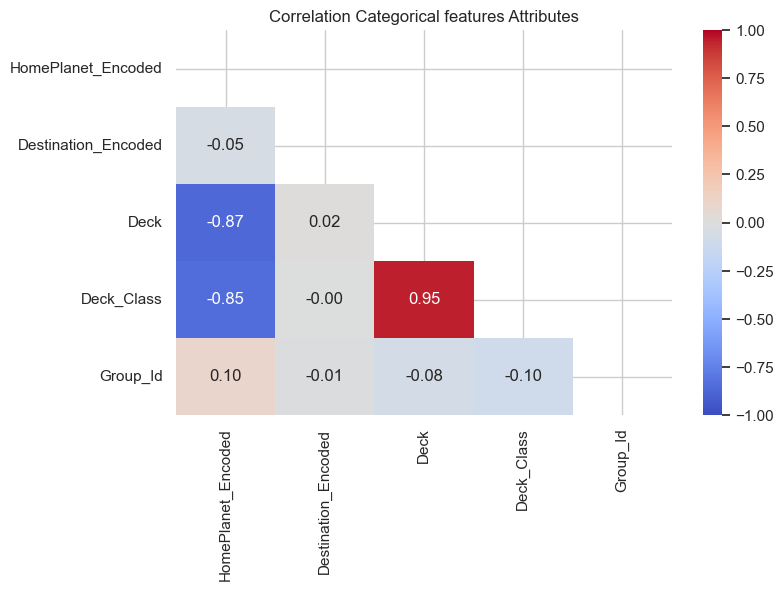

In [355]:
help_tool.heatmap(titanic[['HomePlanet_Encoded', 'Destination_Encoded', 'Deck', 'Deck_Class', 'Group_Id']], 'Categorical features', 'pearson')

* Deck and homeplanet is correlated negatively. One of them will be removed from modeling.

Homeplanet determines deck living area:
* Europa: 1-5
* Mars: 4-6
* Earth: 5-7

Desc living are is filled Europo - Mars -Earth

<Figure size 1200x800 with 0 Axes>

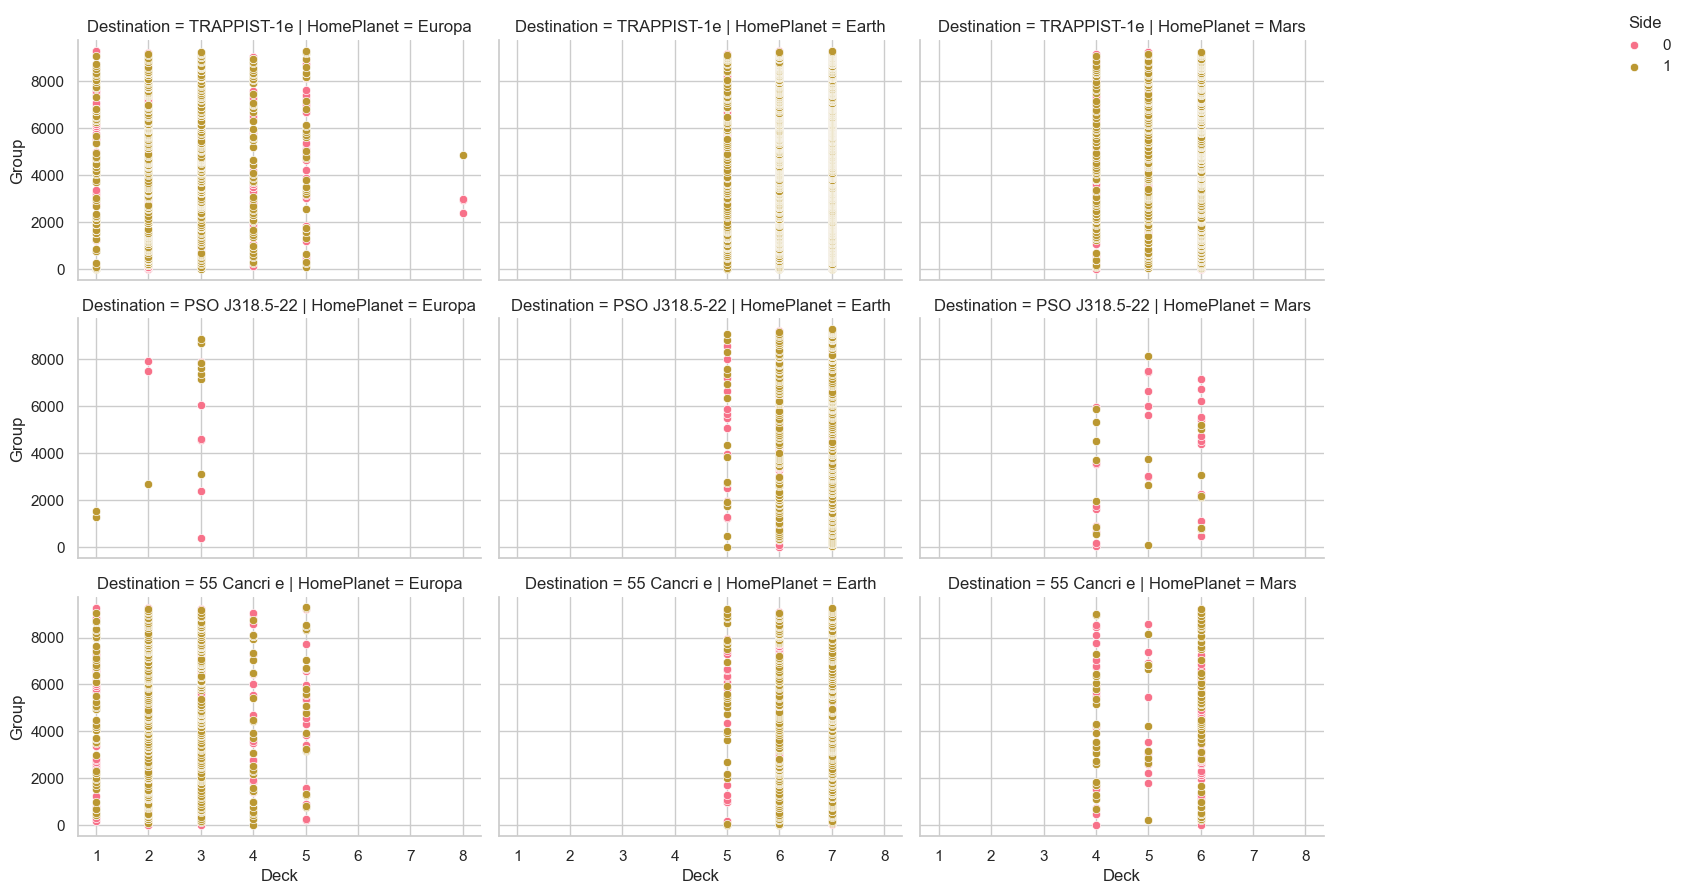

In [356]:
plt.figure(figsize=(12, 8)) 

g = sns.FacetGrid(titanic, row="Destination", col="HomePlanet", hue='Side', height=3, aspect=1.5)

g.map(sns.scatterplot, "Deck", "Group")

g.add_legend(loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

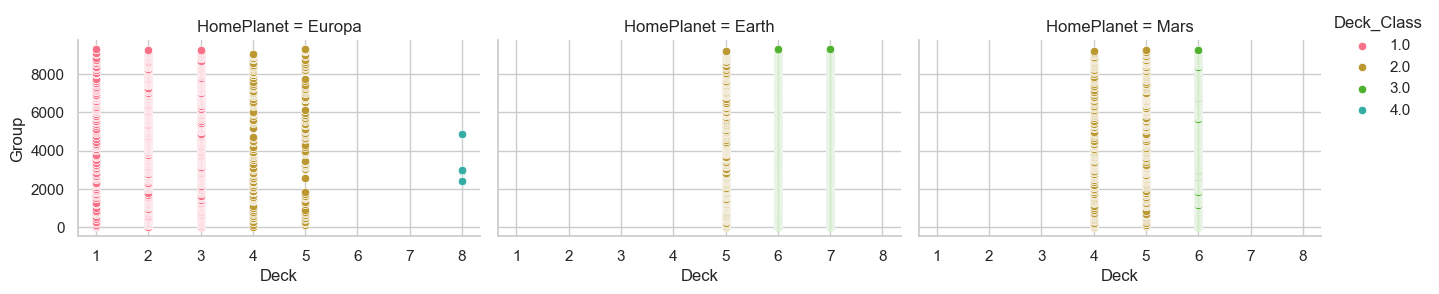

In [357]:
#plt.figure(figsize=(12, 8)) 

g = sns.FacetGrid(titanic, col="HomePlanet", hue='Deck_Class', height=3, aspect=1.5)

g.map(sns.scatterplot, "Deck", "Group")

g.add_legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.show()

Filling in missing HomePlanet with new finding

In [358]:
def filling_homeplanet(df):
    df.loc[df['HomePlanet'].isna() & ((df['Deck'] < 4) | (df['Deck'] == 8)), 'HomePlanet'] = 'Europa'
    df.loc[df['HomePlanet'].isna() & (df['Deck'] == 7), 'HomePlanet'] = 'Earth'
    
    return df

filling_homeplanet(titanic)

titanic[titanic['HomePlanet'].isna()]['Deck'].value_counts()

6.0    70
5.0    23
4.0    10
Name: Deck, dtype: int64

## Binary features

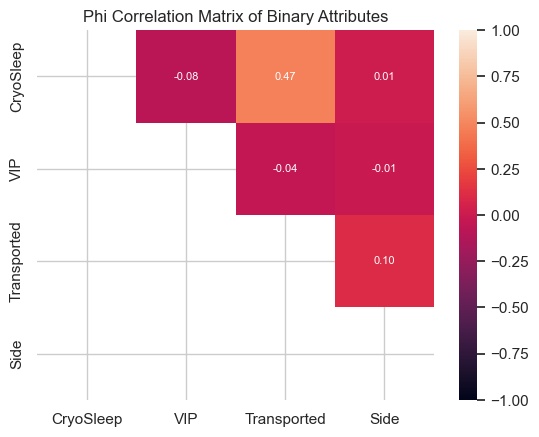

In [359]:
help_tool.phi_corr_matrix(titanic.dropna(), binary_features)

* CryoSleep and Transported is somewhat correlated.

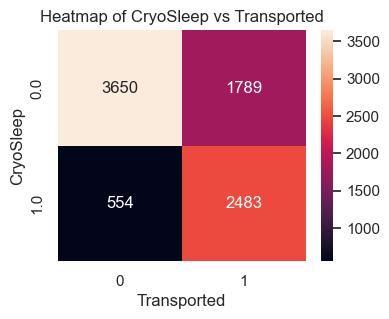

In [360]:
heatmap_data = titanic.groupby(['CryoSleep', 'Transported']).size().unstack()


plt.figure(figsize=(4, 3)) 
sns.heatmap(heatmap_data, annot=True, fmt='d')


plt.xlabel('Transported')
plt.ylabel('CryoSleep')
plt.title('Heatmap of CryoSleep vs Transported')
plt.show()

# Categorical vs Continues features

In [361]:
continues_transformed = ['HomePlanet_Encoded', 'Destination_Encoded', 'Deck', 'Deck_Class', 'Group_Id', 'Amenities', 'Age', 'Group', 'Deck_num']

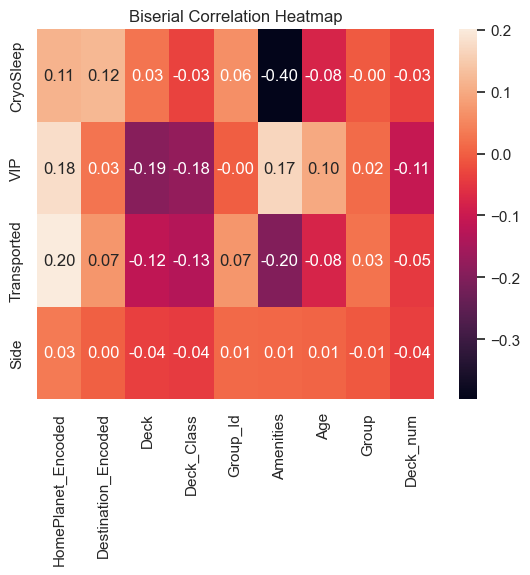

In [362]:
help_tool.biserial_heatmap(titanic.dropna(), continues_transformed, binary_features)

# Missing data
People in a group are often family members, but not always. Let's assume family members with same group and Last Name also share HomePlanet, Cabin and Destination.

In [363]:
def missing_value(df, feature):
    df.sort_values(['Last_Name', 'Group', feature], inplace=True)
    groups = df.groupby(['Last_Name', 'Group'])
    
    for (last_name, group), group_df in groups:
        feature_finding = group_df[feature].dropna().iloc[0] if not group_df[feature].isnull().all() else None
        
        mask = (df['Last_Name'] == last_name) & (df['Group'] == group)
        df.loc[mask, feature] = feature_finding
    
    df.reset_index(drop=True, inplace=True)
    
    return df


for i in ['HomePlanet', 'Cabin', 'Destination']:
    titanic = missing_value(titanic, i)

In [364]:
titanic = help_tool.cabin_split(titanic)
titanic = planet_encoding(titanic)

In [365]:
titanic_filtered = titanic.copy()
titanic_filtered[amenities] = titanic_log[amenities]

In [366]:
titanic_filtered.drop(columns=['Cabin', 'First_Name', 'Last_Name', 'Group', 'Group_Id', 'HomePlanet', 'Destination'], inplace=True)

In [367]:
help_tool.first_look(titanic_filtered)

Dataset has 8693 observations and 24 features
Columns with all empty values []
Dataset has 4 duplicates


,dtypes,"Null values, Count","Null values, %"
CryoSleep,float64,217,2.5
Age,float64,179,2.1
VIP,float64,203,2.3
RoomService,float64,113,1.3
FoodCourt,float64,113,1.3
ShoppingMall,float64,112,1.3
Spa,float64,118,1.4
VRDeck,float64,126,1.4
Transported,int32,0,0.0
Deck,float64,110,1.3


Filling in categorical values with mode

In [371]:
for i in ['CryoSleep', 'VIP', 'HomePlanet_Encoded', 'Transported', 'Deck_Class', 'Deck', 'Side', 'Family', 'HomePlanet_Encoded', 'Destination_Encoded', 'GroupSize']:
    titanic_filtered[i].fillna(titanic_filtered[i].mode()[0], inplace=True)

In [376]:
for i in (['Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Deck_num', 'Amenities'] + avg_amenities):
    titanic_filtered[i].fillna(titanic_filtered[i].mean(), inplace=True)

# Mutal Information gain

In [378]:
titanic_filtered.isna().sum()

CryoSleep              0
Age                    0
VIP                    0
RoomService            0
FoodCourt              0
ShoppingMall           0
Spa                    0
VRDeck                 0
Transported            0
Deck                   0
Deck_num               0
Side                   0
Deck_Class             0
Amenities              0
GroupSize              0
Family                 0
HomePlanet_Encoded     0
Destination_Encoded    0
Avg_RoomService        0
Avg_FoodCourt          0
Avg_ShoppingMall       0
Avg_Spa                0
Avg_VRDeck             0
Avg_Amenities          0
dtype: int64

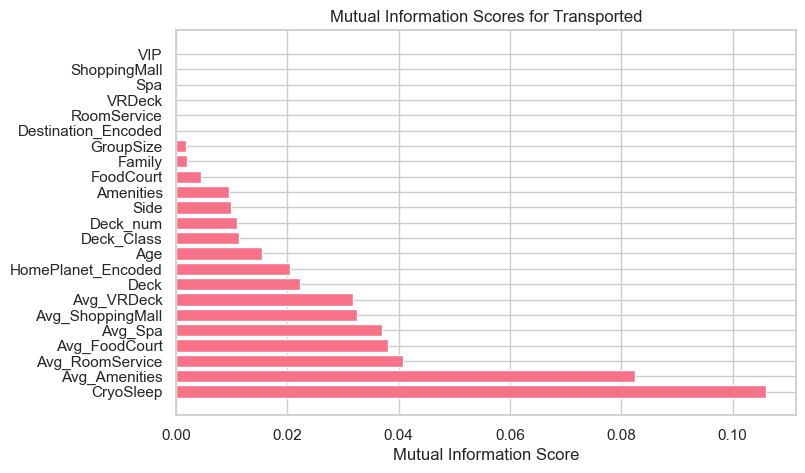

In [379]:
X = titanic_filtered.drop(['Transported'], axis=1)
y = titanic_filtered['Transported']

# Compute mutual information scores
mi_scores = pd.DataFrame(mutual_info_classif(
    X, y), index=X.columns, columns=['Mutual Information Gain'])
mi_scores.sort_values(by='Mutual Information Gain',
                      ascending=False, inplace=True)

# Visualize the scores
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)

plt.figure(dpi=100, figsize=(8, 5))
plt.barh(width, mi_scores['Mutual Information Gain'])
plt.yticks(width, ticks)
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information Scores for Transported")
plt.show()